In [1]:
import matplotlib.pyplot as plt

from starter_code import (
    ani1_config,
    load_ani1_data,
    calc_resid,
    compute_rmse_by_num_heavy_atoms,
    plot_rmse_by_num_heavy_atoms,
    compute_rmse_by_num_bonds,
    plot_rmse_by_num_bonds,
    isin_tuple_series
)
import pandas as pd

In [2]:
molecules = load_ani1_data()

data file path is ./ANI-1ccx_clean_fullentry.h5


In [3]:
# Calculate the residual vector for each method-method combination
resid = calc_resid(molecules)

Calculating residuals: 100%|██████████| 91/91 [00:10<00:00,  8.70it/s]


In [4]:
rmse_df = compute_rmse_by_num_heavy_atoms(molecules, resid, ani1_config["heavy_atoms"])


Computing RMSE: 100%|██████████| 91/91 [00:53<00:00,  1.71it/s]


In [5]:
rmse_df

,RMSE,RMSE / sqrt(nh),Heavy Atoms,Method Pair,STD,n
0,0.791352,0.791352,1,"(dt, pt)",0.785181,389
1,0.759310,0.536914,2,"(dt, pt)",0.751982,2782
2,0.864054,0.498862,3,"(dt, pt)",0.863568,3704
3,1.244858,0.622429,4,"(dt, pt)",1.235344,6188
4,1.131226,0.505900,5,"(dt, pt)",1.129610,21349
...,...,...,...,...,...,...
3,1.056132,0.528066,4,"(nt, cc)",1.055776,6188
4,1.137655,0.508775,5,"(nt, cc)",1.134560,21349
5,1.294737,0.528574,6,"(nt, cc)",1.290116,42658
6,1.327763,0.501847,7,"(nt, cc)",1.326193,38953


In [36]:

# Will produce 91 plots, one for each method-method combination
# plot_rmse_by_num_heavy_atoms(rmse_df)

# Will produce a plot for each dftb-method combination
# plot_rmse_by_num_heavy_atoms(
#     rmse_df[isin_tuple_series("dt", rmse_df["Method Pair"])],
#     method_id_to_name=ani1_config["target"],
# )


In [7]:
rmse_df_nbonds = compute_rmse_by_num_bonds(molecules, resid)

Computing RMSE:   0%|          | 0/91 [00:00<?, ?it/s]c:\Users\Sage\Documents\CMU\99519\Code\summer22-analysis\starter_code.py:627: RuntimeWarning: divide by zero encountered in double_scalars
  rmse_nbond_vals.append(rmse_val / num_bonds**0.5)
Computing RMSE: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s] 


In [35]:
# plot_rmse_by_num_bonds(
#     rmse_df_nbonds[isin_tuple_series("dt", rmse_df_nbonds["Method Pair"])],
#     method_id_to_name=ani1_config["target"],
# )

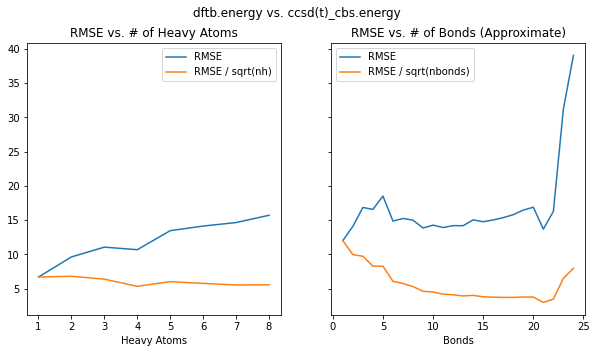

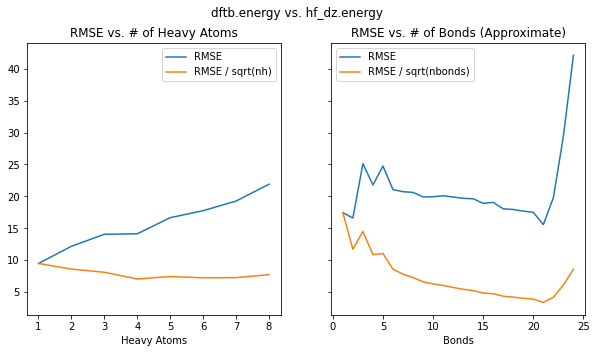

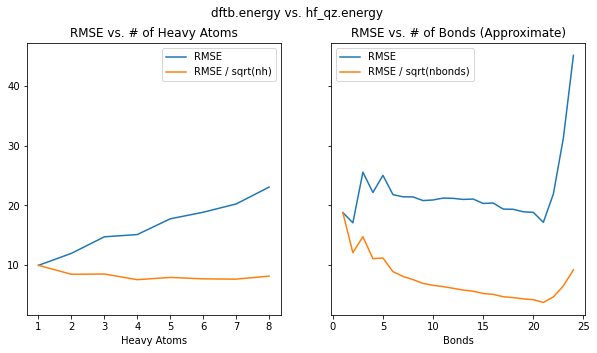

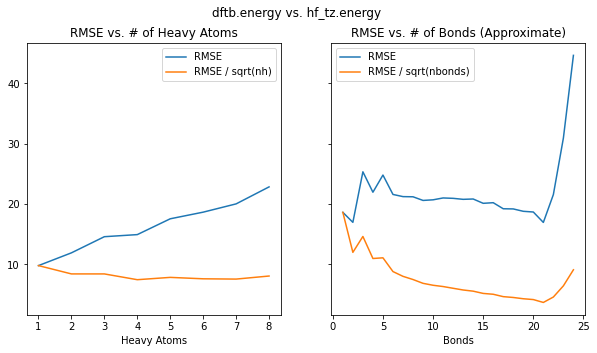

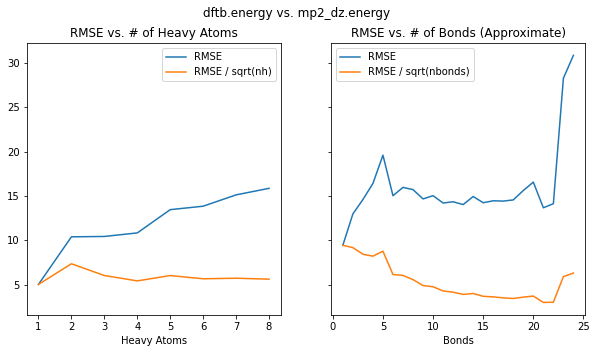

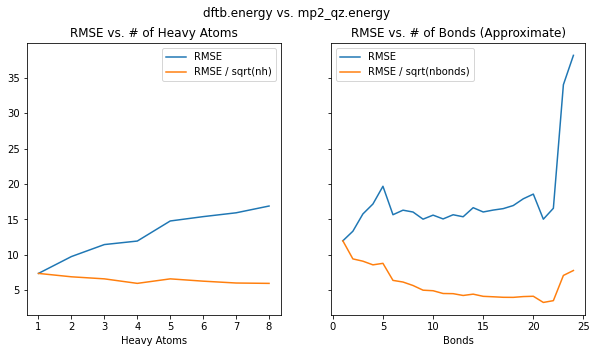

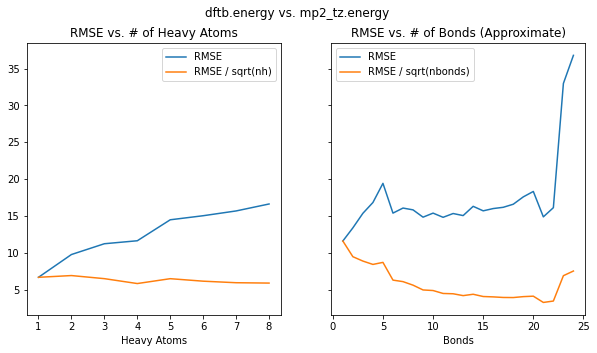

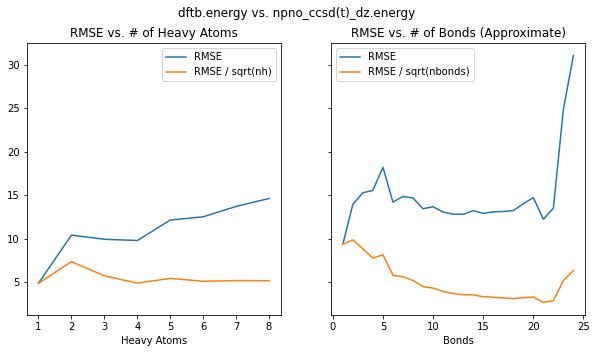

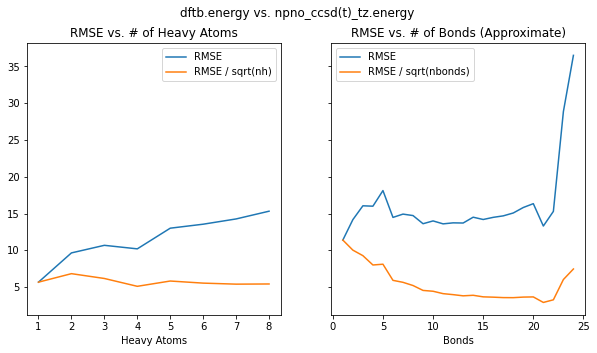

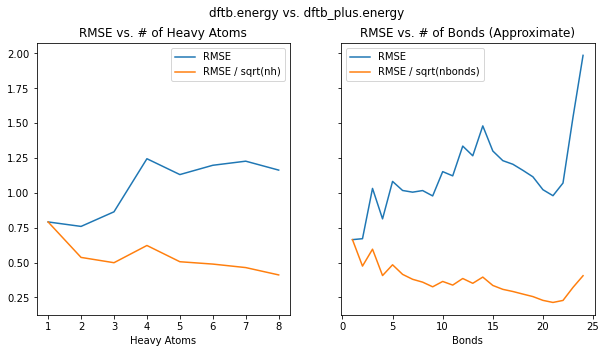

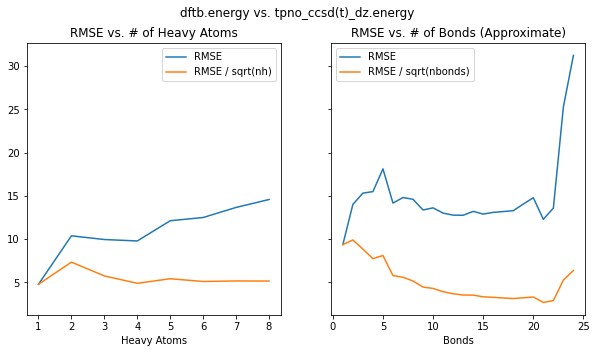

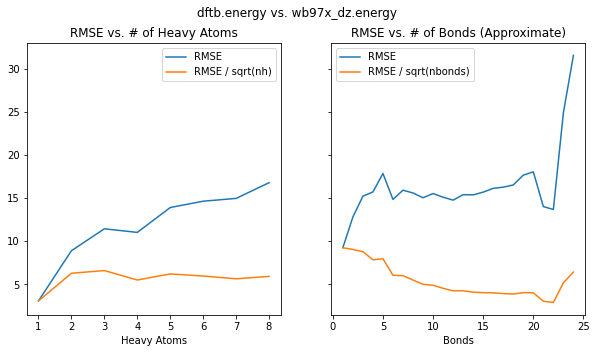

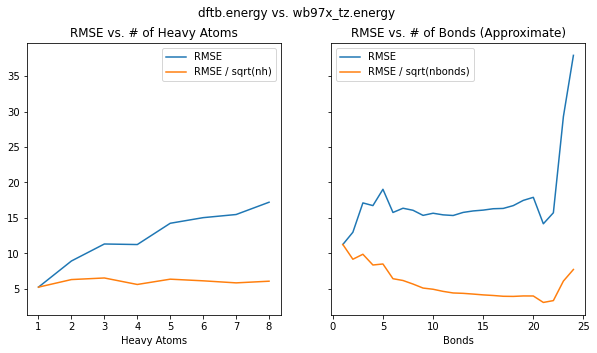

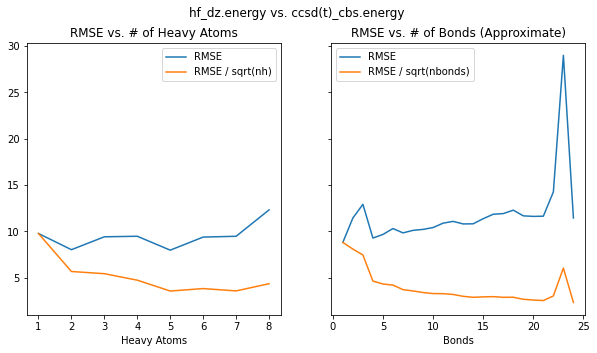

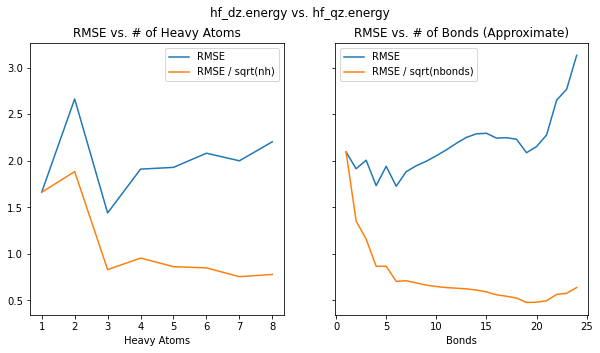

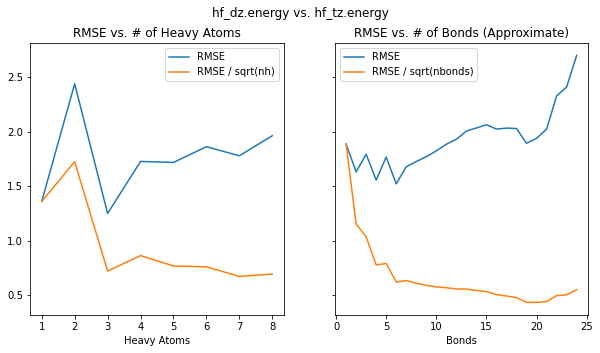

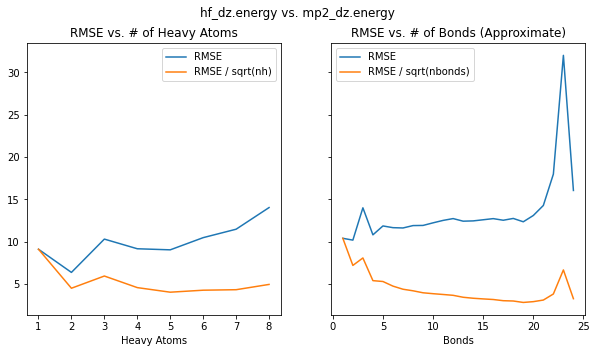

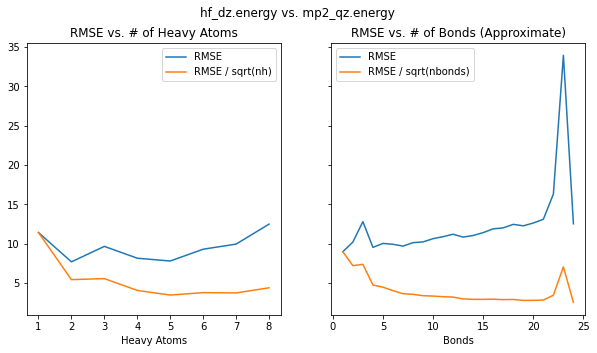

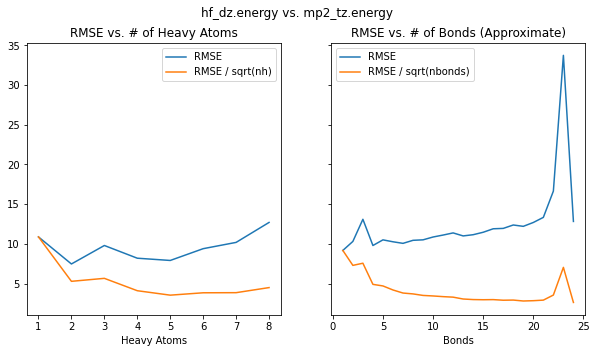

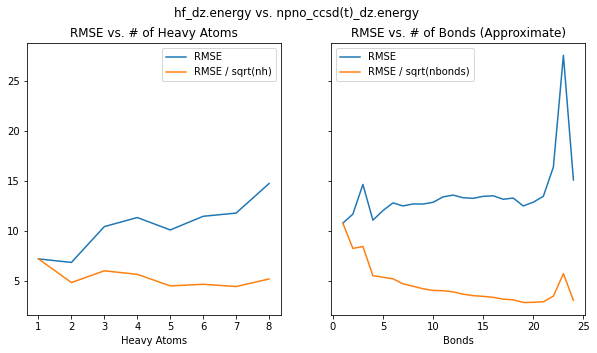

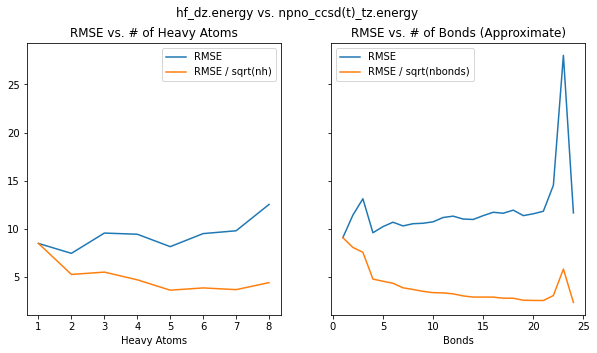

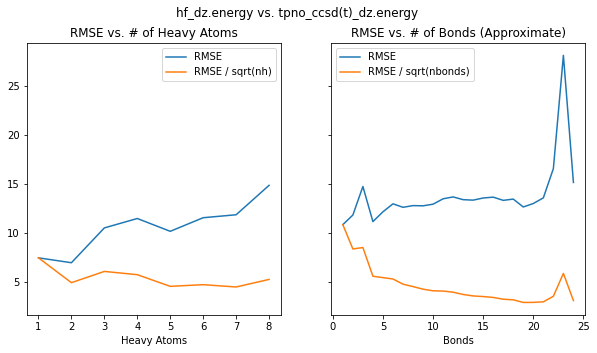

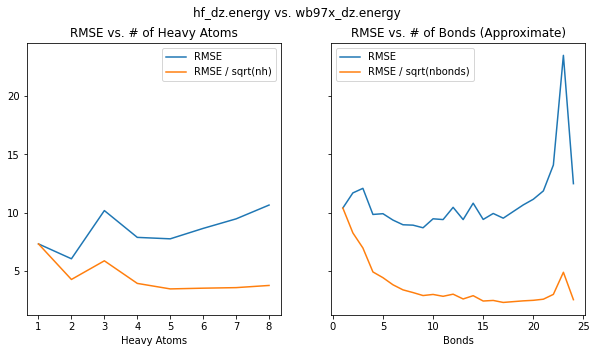

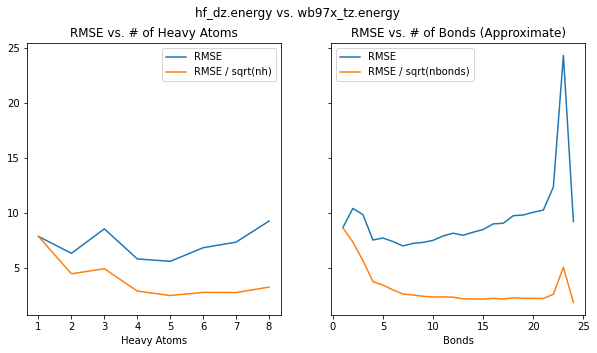

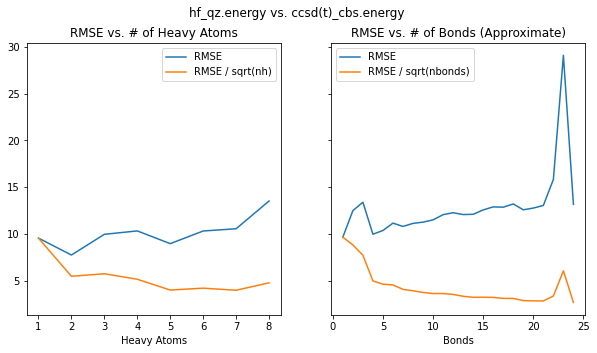

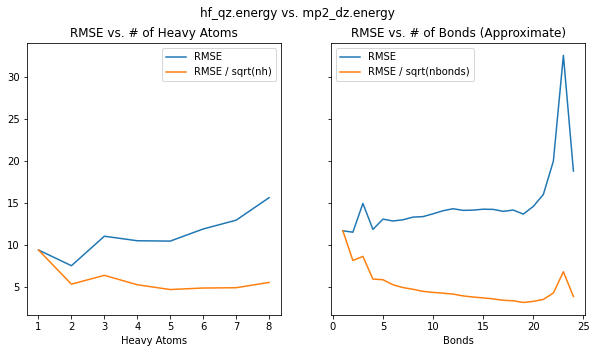

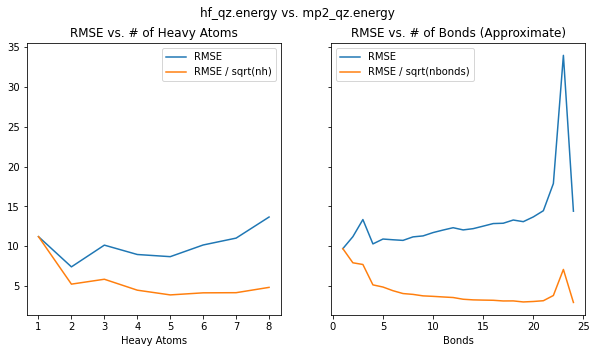

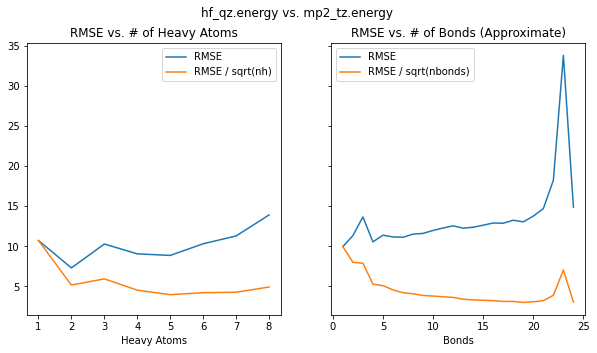

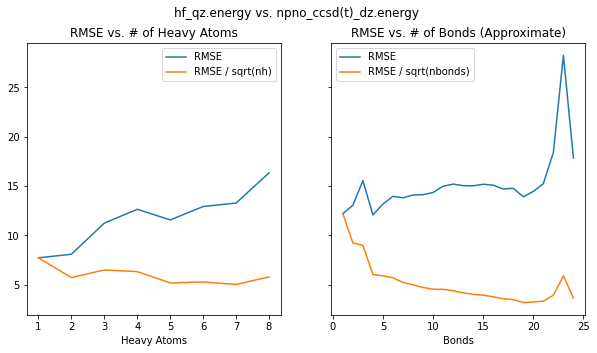

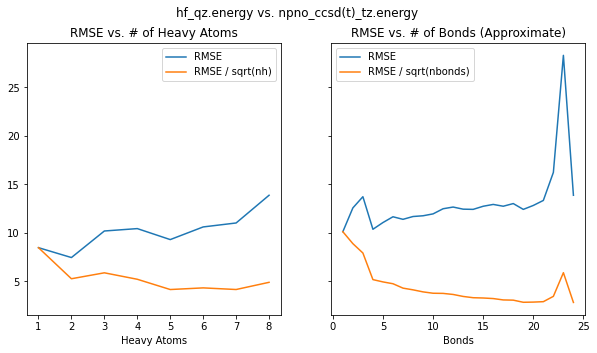

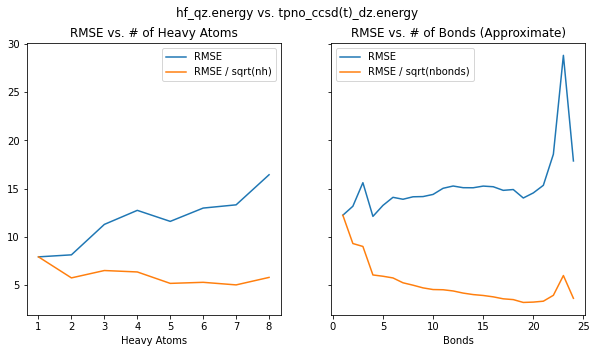

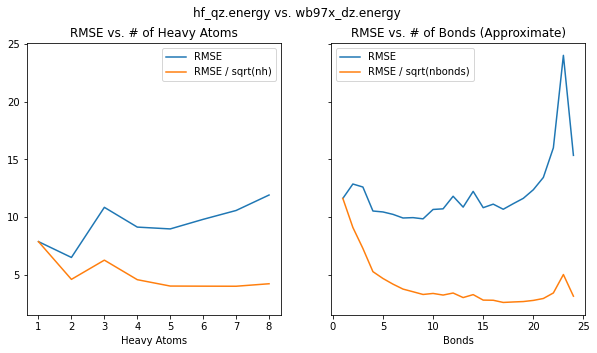

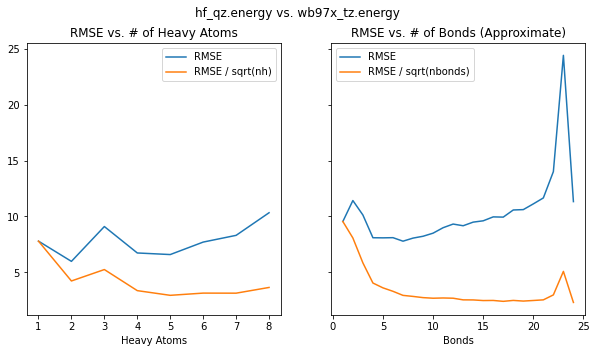

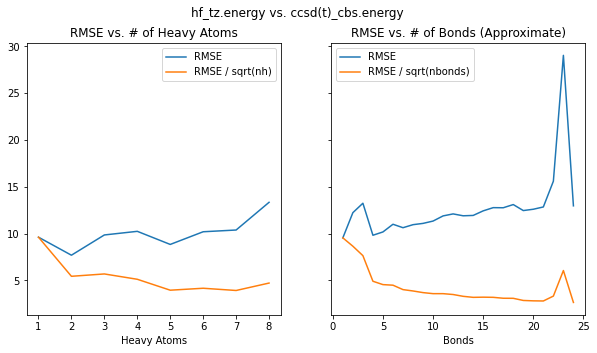

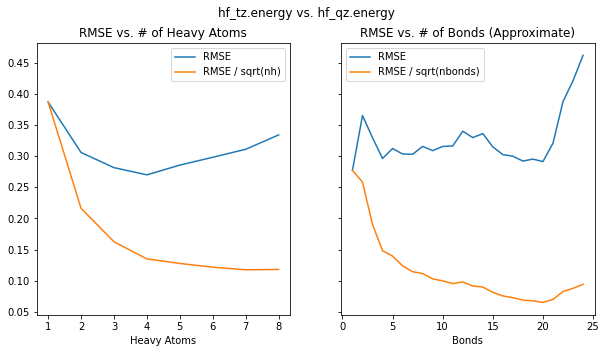

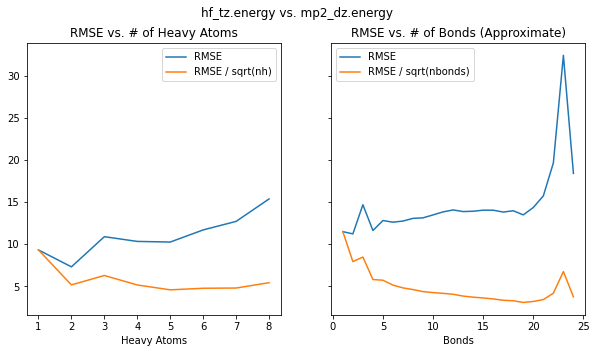

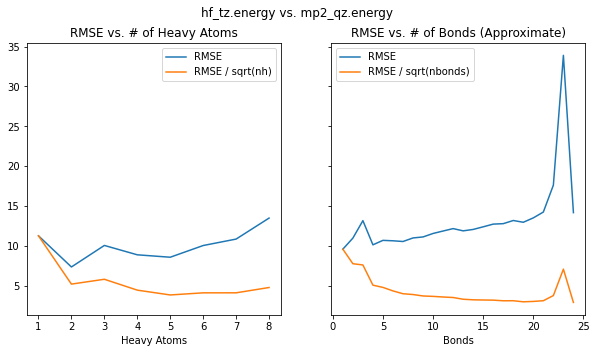

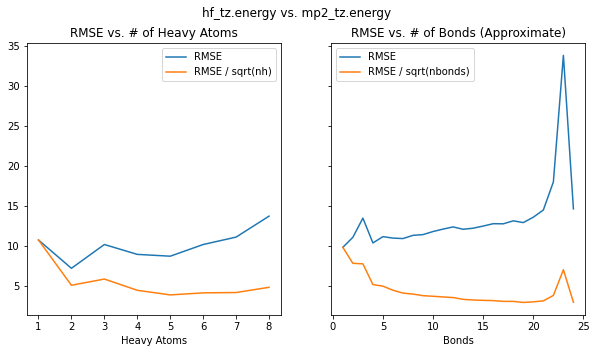

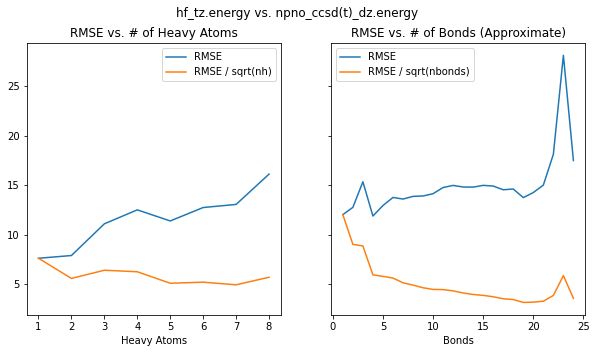

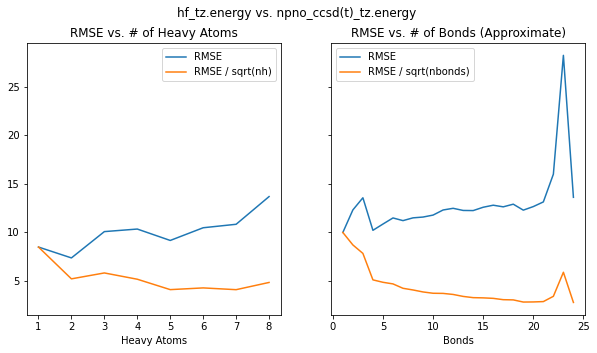

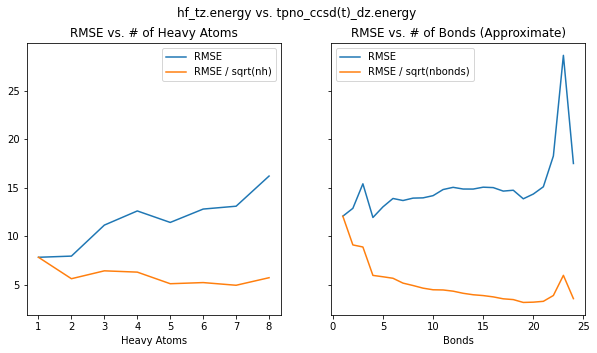

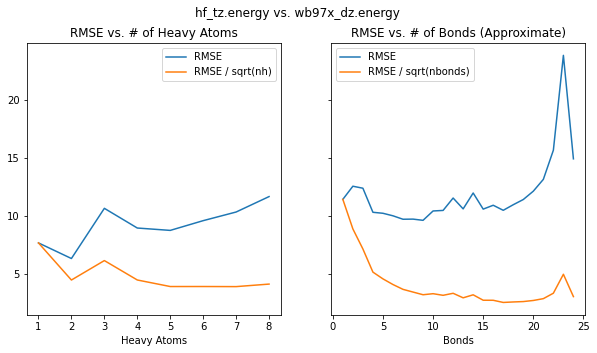

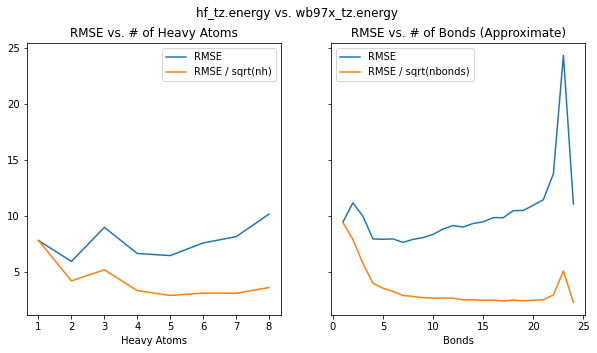

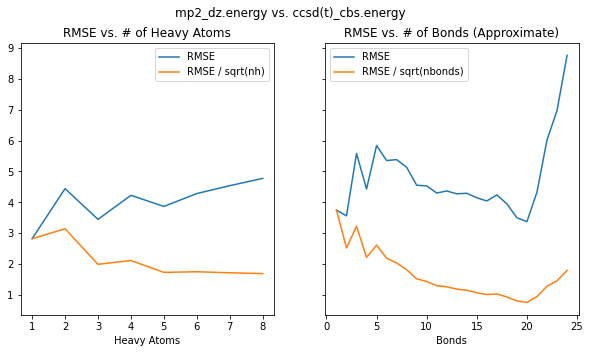

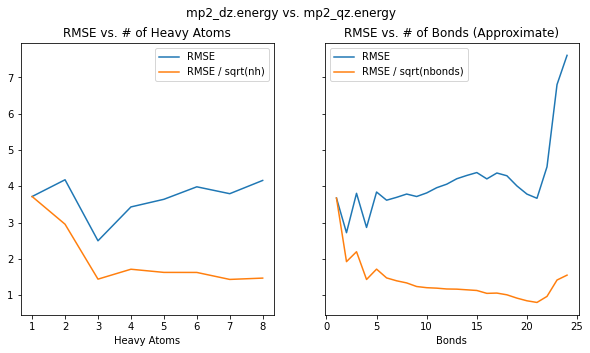

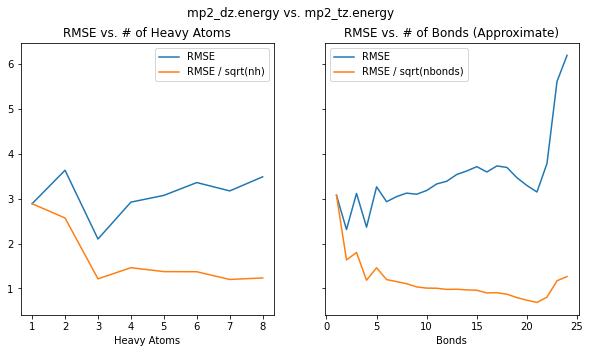

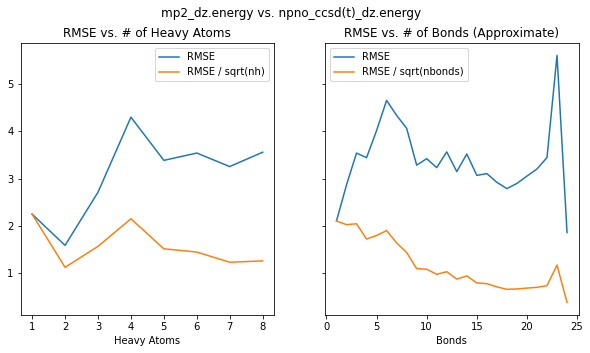

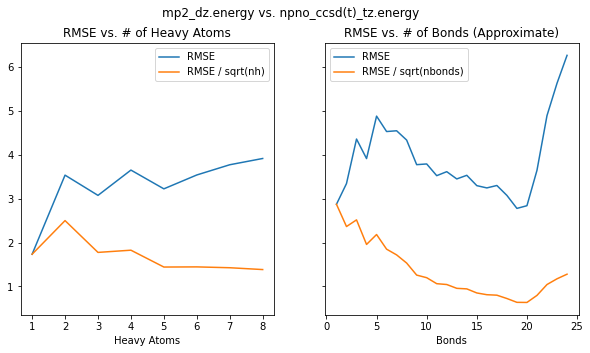

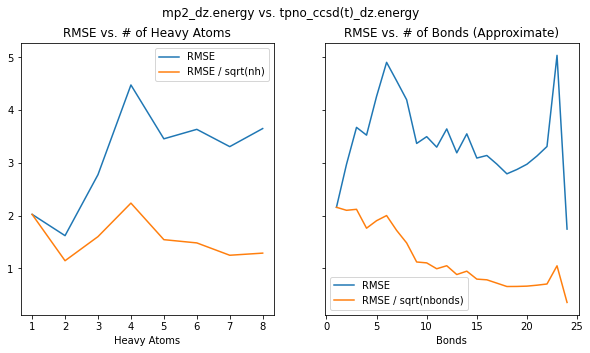

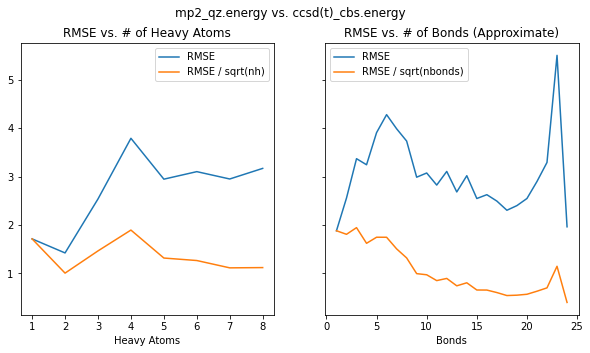

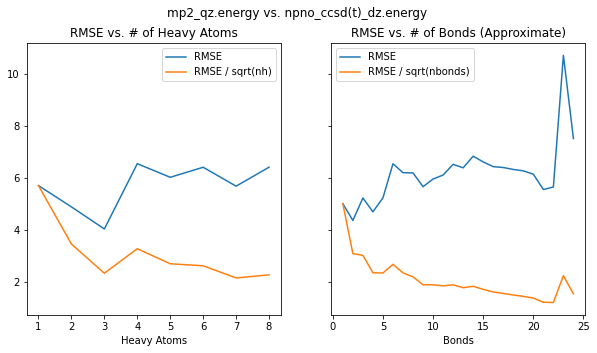

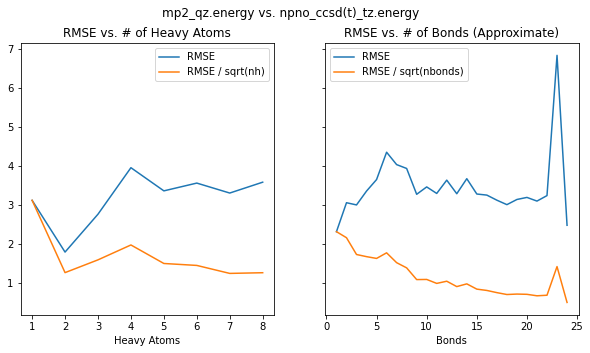

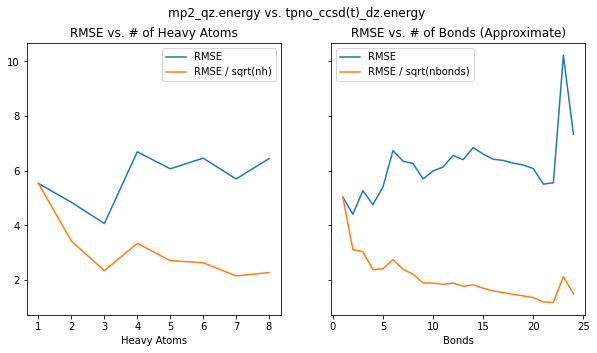

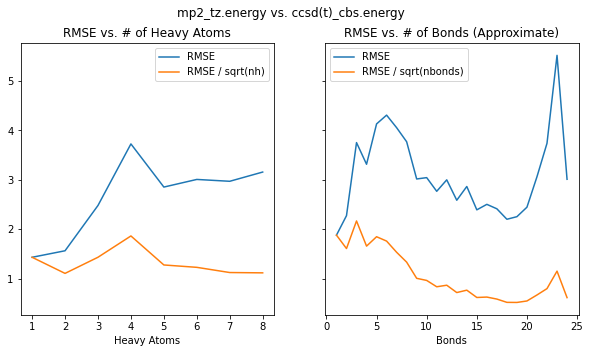

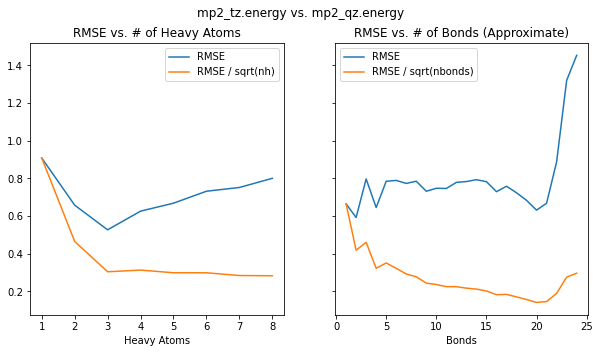

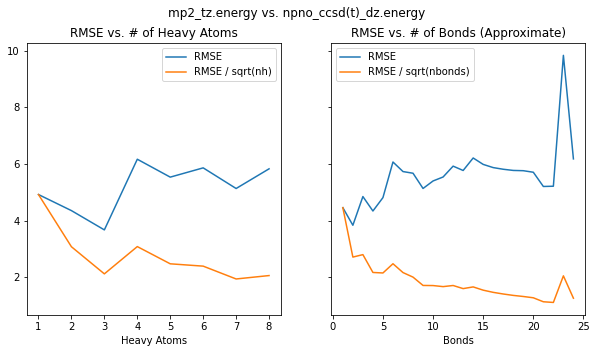

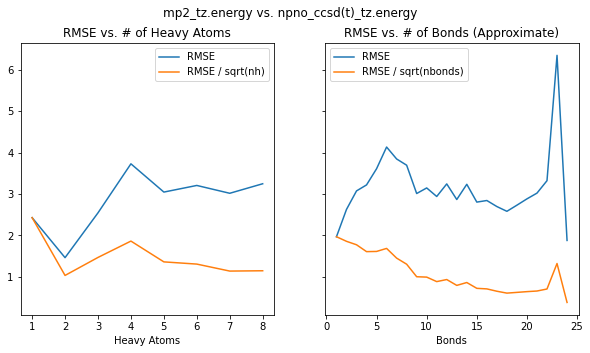

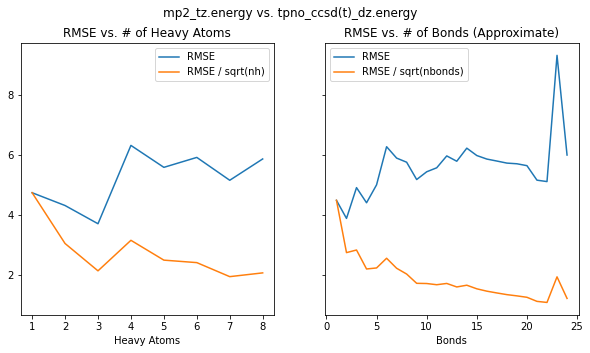

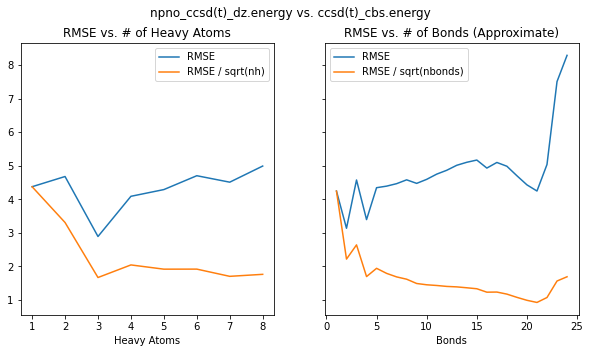

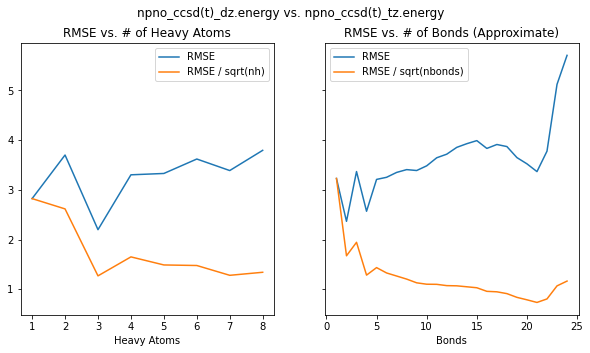

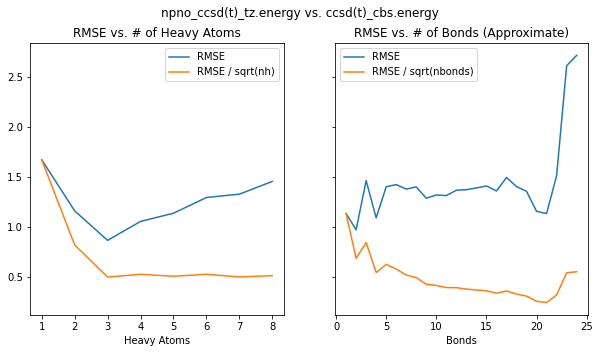

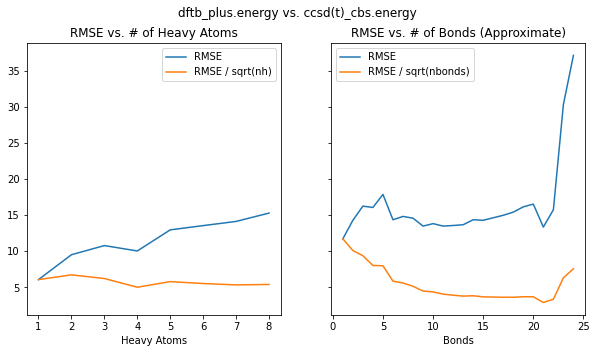

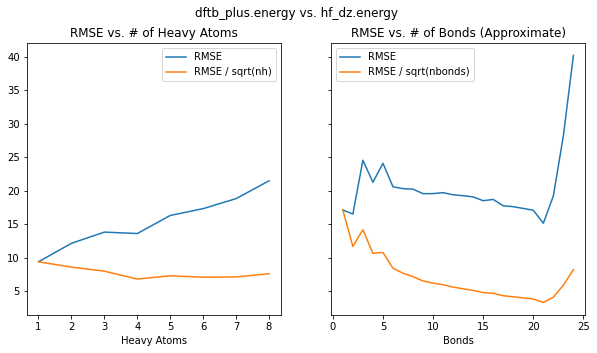

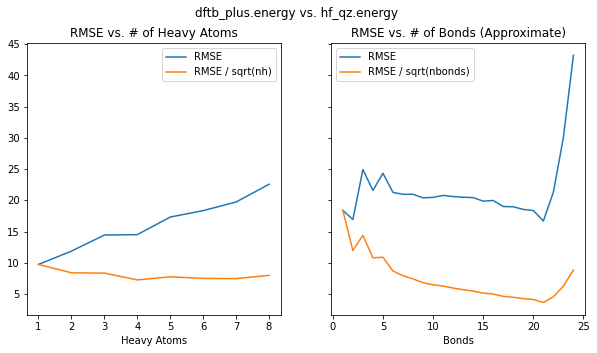

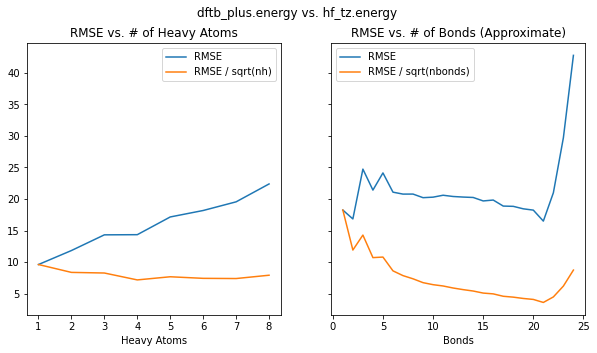

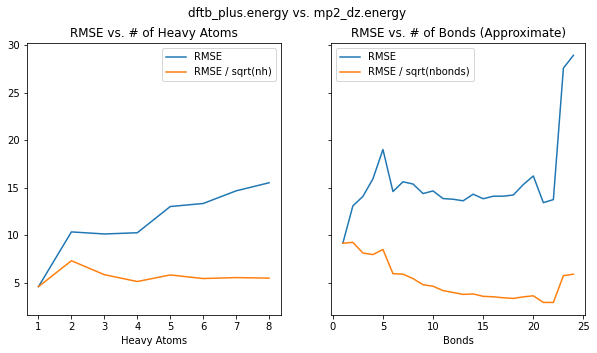

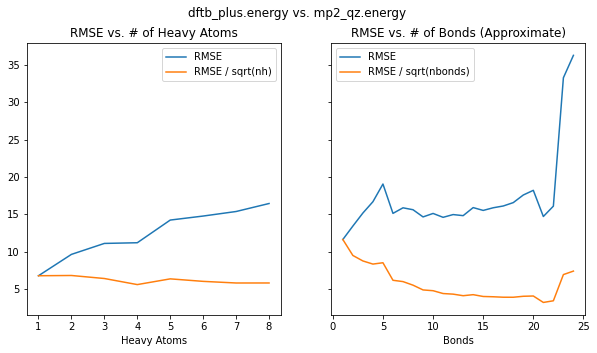

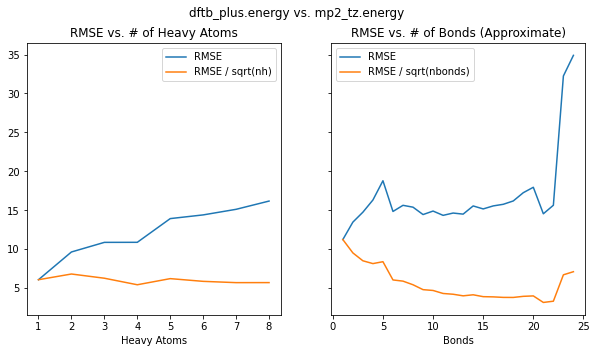

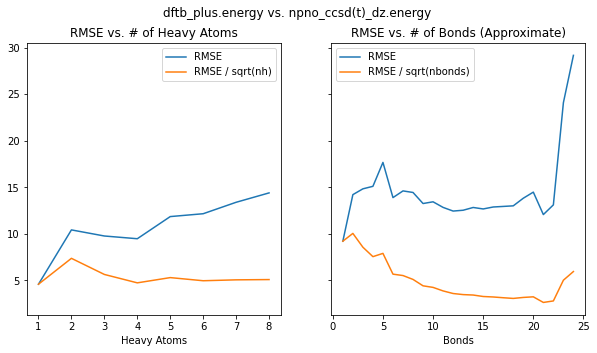

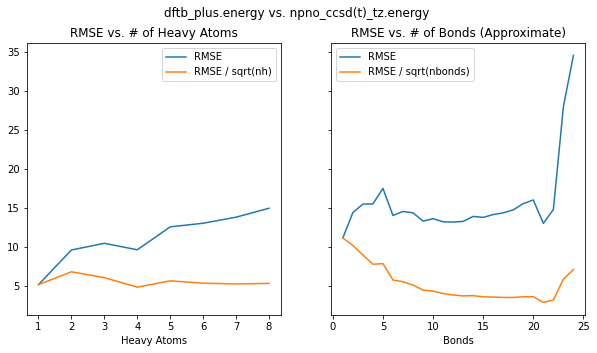

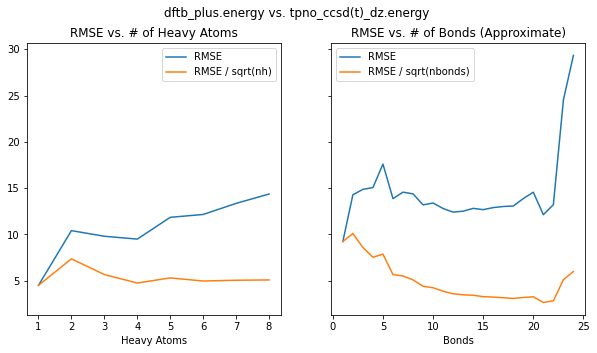

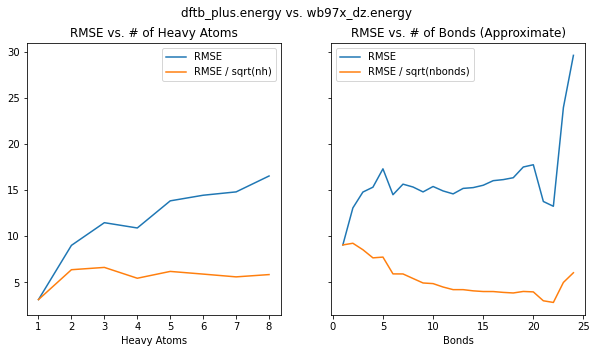

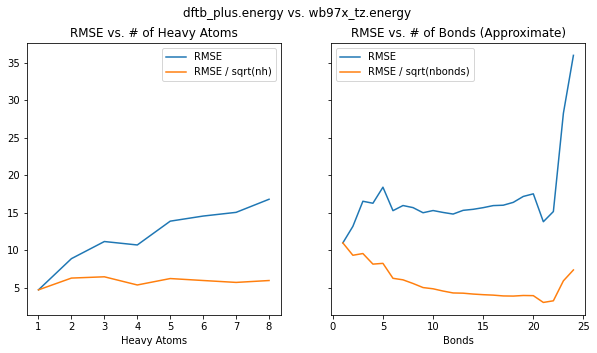

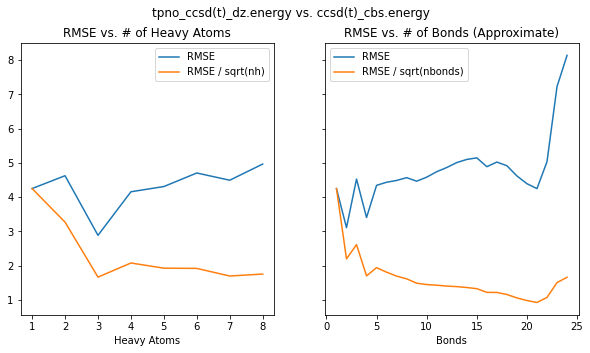

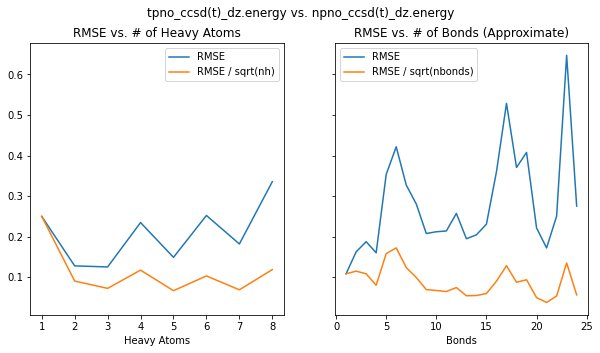

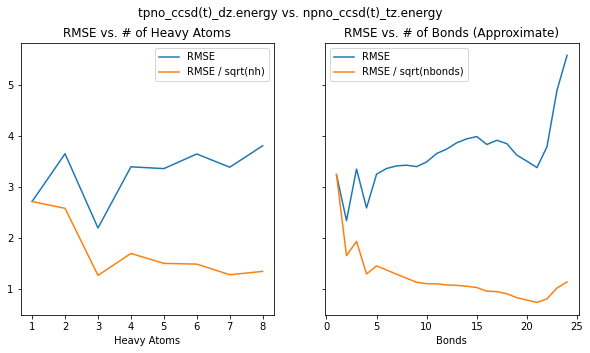

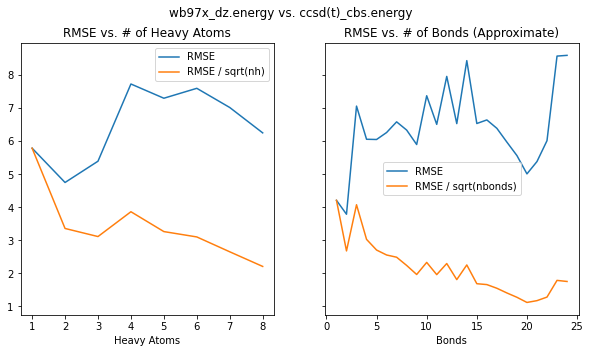

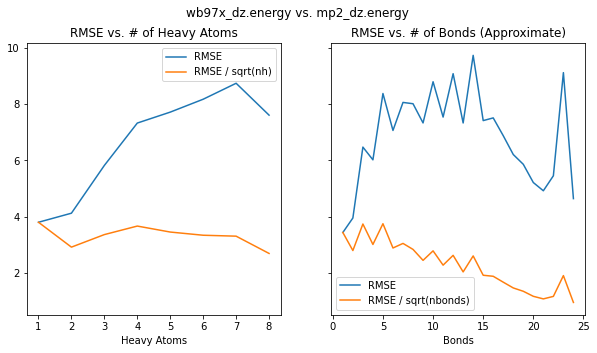

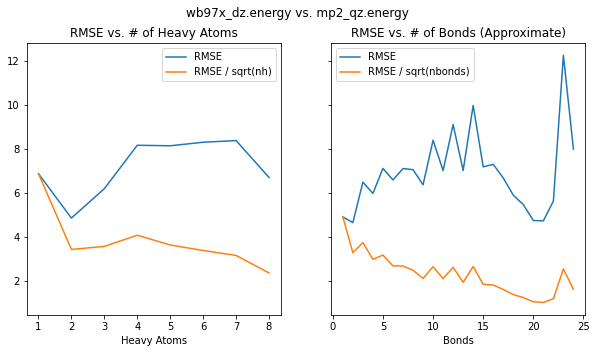

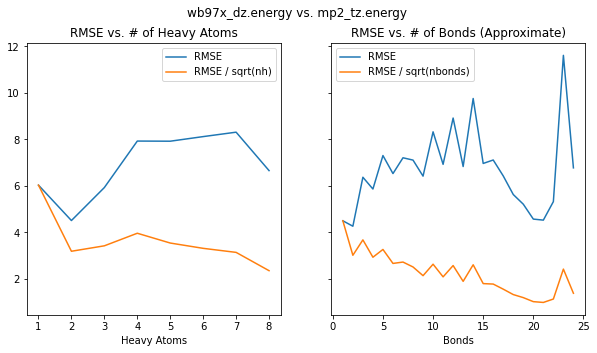

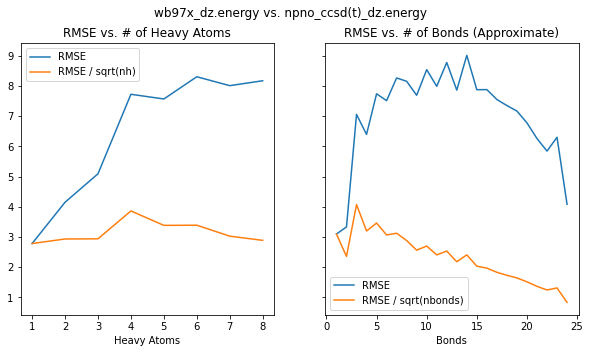

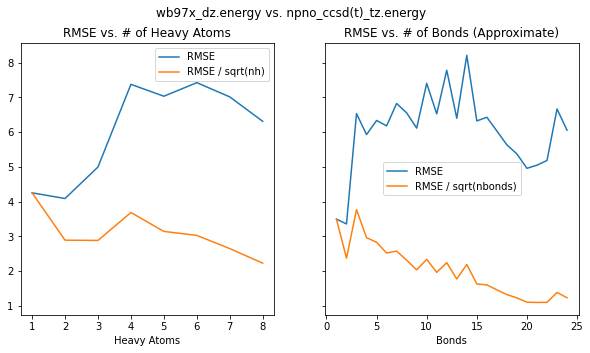

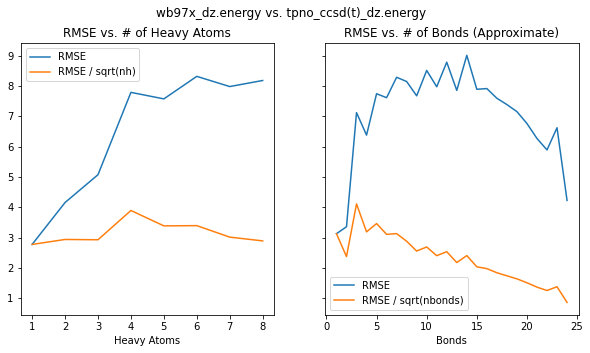

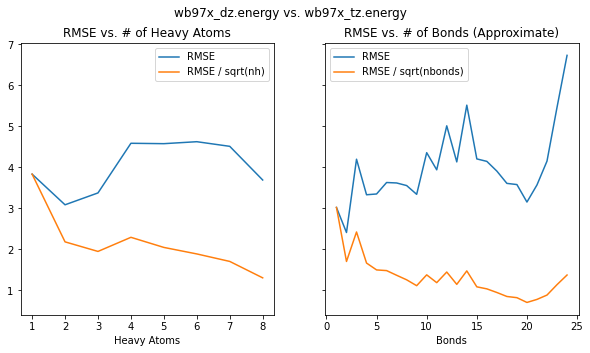

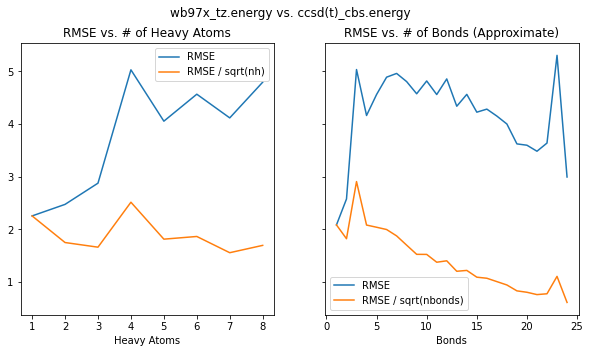

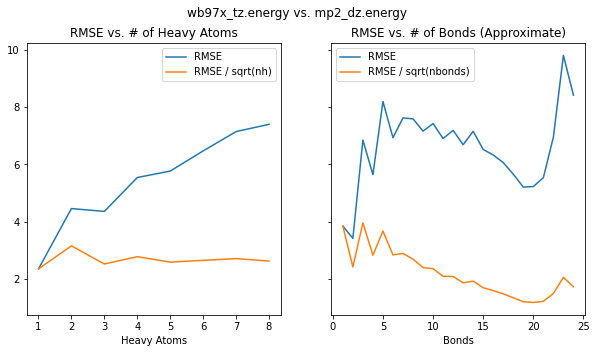

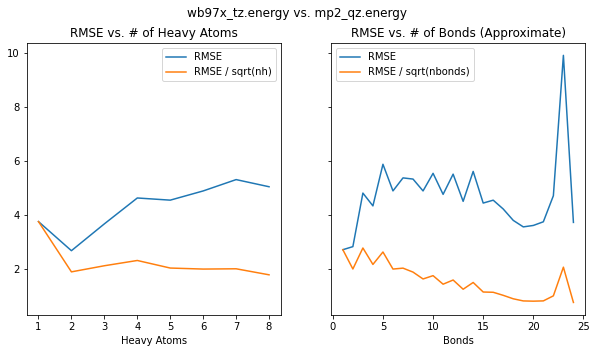

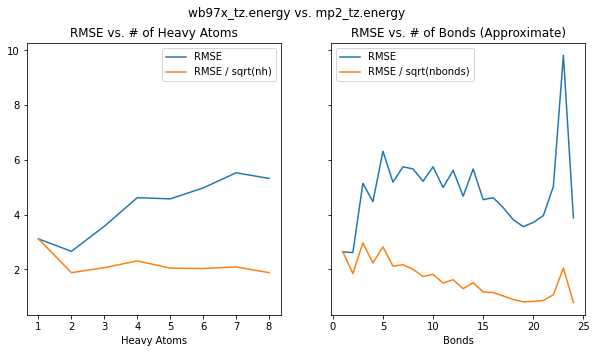

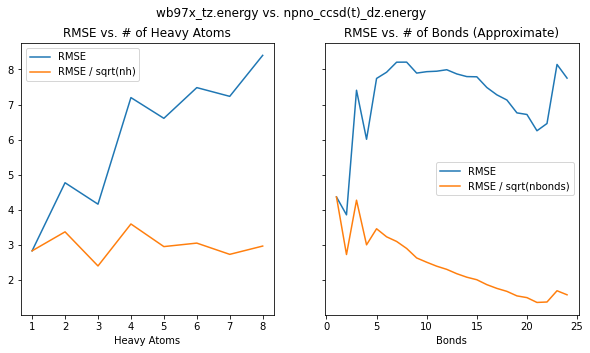

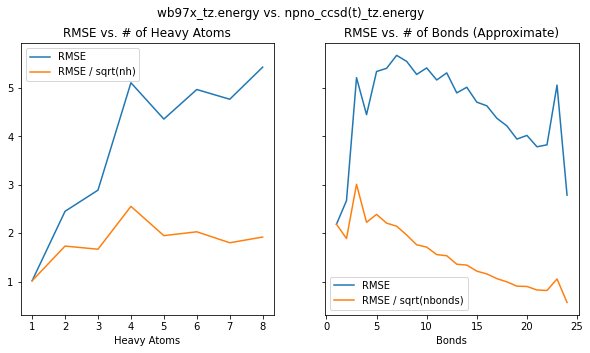

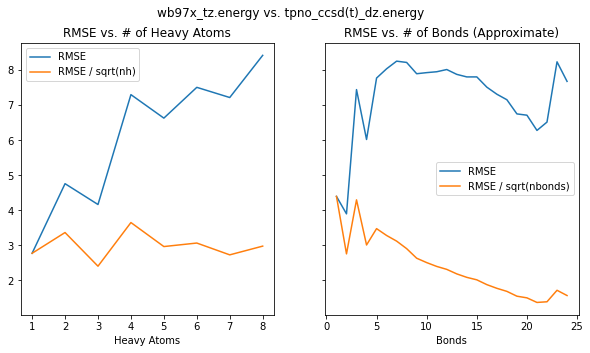

In [38]:
rmse_df_nbonds_groupby = rmse_df_nbonds.groupby("Method Pair")
for (method1, method2), group in rmse_df.groupby("Method Pair"):
    method1_full_name = ani1_config["target"][method1]
    method2_full_name = ani1_config["target"][method2]

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
    fig.suptitle(f"{method1_full_name} vs. {method2_full_name}")

    title = f"RMSE vs. # of Heavy Atoms"
    group.set_index("Heavy Atoms")[["RMSE", "RMSE / sqrt(nh)"]].plot(title=title, ax=ax[0])

    group = rmse_df_nbonds_groupby.get_group((method1, method2))
    group = group[group["Bonds"] != 0]
    title = f"RMSE vs. # of Bonds (Approximate)"
    group.set_index("Bonds").sort_index()[["RMSE", "RMSE / sqrt(nbonds)"]].plot(
        title=title, ax=ax[1]
    )

    plt.show()

In [43]:
molecule = molecules[100622]
molecule["name"], molecule["iconfig"], molecule["atomic_numbers"]

('C3H7N3O1', 0, array([6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 8], dtype=uint8))

In [49]:
from scipy.spatial.distance import cdist
import numpy as np

atom_types = {1: 'H', 6: 'C', 7: 'N', 8: 'O'}

ATOM_PAIR_TO_BOND_ANGSTROM = {
    frozenset([1, 6]): (0.95, 1.70),
    frozenset([1, 7]): (0.95, 1.50),
    frozenset([1, 8]): (0.90, 1.50),
    frozenset([6, 6]): (1.00, 1.90),
    frozenset([6, 7]): (1.10, 1.80),
    frozenset([6, 8]): (1.10, 1.75),
}

def bonds_from_coordinates(coordinates, atomic_numbers):
    pairwise_distance = cdist(coordinates, coordinates)

    bonds = []
    # Loop through combinations of atoms in the molecule
    # Only need to look at one half of the (symmetric) pairwise distance matrix
    # And we don't care about the diagonal either
    for i, j in zip(*np.triu_indices_from(pairwise_distance, k=1)):
        atom_atom_distance = pairwise_distance[i, j]
        atomic_number_pair = frozenset([atomic_numbers[i], atomic_numbers[j]])
        bond_length_min_max = ATOM_PAIR_TO_BOND_ANGSTROM.get(atomic_number_pair)

        # If we have the current atom-atom pair in the bond length lookup table, 
        # check if the distance is within the allowed range
        if bond_length_min_max is not None:
            bond_length_min, bond_length_max = bond_length_min_max
            if bond_length_min < atom_atom_distance < bond_length_max:
                bonds.append((i, j))

    return bonds


In [75]:
from math import dist

atomic_numbers = molecule["atomic_numbers"]
coordinates = molecule["coordinates"]

bonds = bonds_from_coordinates(coordinates, atomic_numbers)

bond_numbers = [(atomic_numbers[b[0]], atomic_numbers[b[1]]) for b in bonds]
bond_symbols = [(atom_types[n[0]], atom_types[n[1]]) for n in bond_numbers]
bond_distances = [dist(coordinates[b[0]], coordinates[b[1]]) for b in bonds]

pd.DataFrame({"Atom Indices": bonds, "Atomic Numbers": bond_numbers, "Bond Symbols": bond_symbols, "Bond Distance": bond_distances})

,Atom Indices,Atomic Numbers,Bond Symbols,Bond Distance
0,"(0, 3)","(6, 1)","(C, H)",1.090987
1,"(0, 4)","(6, 1)","(C, H)",1.013165
2,"(0, 5)","(6, 1)","(C, H)",1.181518
3,"(0, 10)","(6, 7)","(C, N)",1.471816
4,"(1, 6)","(6, 1)","(C, H)",1.221394
5,"(1, 10)","(6, 7)","(C, N)",1.398434
6,"(1, 11)","(6, 7)","(C, N)",1.260010
7,"(2, 10)","(6, 7)","(C, N)",1.399548
8,"(2, 12)","(6, 7)","(C, N)",1.384037
9,"(2, 13)","(6, 8)","(C, O)",1.325867


In [19]:
from rdkit import Chem

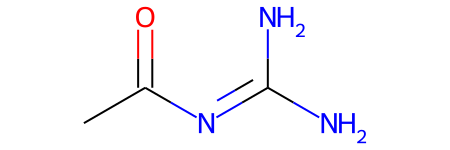

In [20]:
# N-(diaminomethylidene)acetamide -- Canonical SMILES
m = Chem.MolFromSmiles('CC(=O)N=C(N)N')
m

In [21]:
for bond in m.GetBonds():
    print(f"{bond.GetBeginAtom().GetSymbol()}-{bond.GetEndAtom().GetSymbol()} {bond.GetBondType()} bond")

C-C SINGLE bond
C-O DOUBLE bond
C-N SINGLE bond
N-C DOUBLE bond
C-N SINGLE bond
C-N SINGLE bond


Our bond detection seemed to have missed the C-C bond.

We should expect one of the carbon atom pairs in the distance matrix to have a pairwise distance roughly between 1.2 and 1.54. However, the distances between the carbon atoms are 2.44 and 2.49 from the ANI-1 data (see the first few entries in the table below).

In [22]:
# Printing the distance matrix
print("Atomic #:", "     ".join([str(x) for x in molecule["atomic_numbers"]]))
for row in cdist(molecule["coordinates"], molecule["coordinates"]):
    print("         ", "  ".join([f"{x:.2f}"for x in row]))

Atomic #: 6     6     6     1     1     1     1     1     1     1     7     7     7     8
          0.00  2.44  2.49  1.09  1.01  1.18  2.53  4.46  4.47  4.13  1.47  3.53  3.79  2.66
          2.44  0.00  2.44  3.41  2.32  2.99  1.22  2.04  4.03  2.71  1.40  1.26  2.91  3.51
          2.49  2.44  0.00  2.91  3.23  2.71  3.35  3.62  2.00  2.10  1.40  2.63  1.38  1.33
          1.09  3.41  2.91  0.00  1.79  1.72  3.60  5.36  4.75  4.66  2.26  4.39  4.25  2.75
          1.01  2.32  3.23  1.79  0.00  1.87  2.08  4.32  5.23  4.51  1.93  3.52  4.38  3.62
          1.18  2.99  2.71  1.72  1.87  0.00  2.88  4.94  4.50  4.57  2.05  4.05  4.01  2.45
          2.53  1.22  3.35  3.60  2.08  2.88  0.00  2.75  5.02  3.89  2.14  2.30  3.99  4.16
          4.46  2.04  3.62  5.36  4.32  4.94  2.75  0.00  4.36  2.49  3.19  1.03  3.22  4.88
          4.47  4.03  2.00  4.75  5.23  4.50  5.02  4.36  0.00  2.15  3.34  3.64  1.20  2.35
          4.13  2.71  2.10  4.66  4.51  4.57  3.89  2.49  2.15  0.00  2.6